In [152]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [153]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [154]:
def rmse(predictions, targets): 

    return np.sqrt(((predictions - targets) ** 2).mean())

In [158]:
def metric(rf):
    print("Traning Score")
    print(rf.score(x_train,y_train))
    print("Test Score")
    print(rf.score(x_test,y_test))
    print("MAE Train")
    train=np.rint(rf.predict(x_train))
    test=np.rint(rf.predict(x_test))
    print(mean_absolute_error(train, y_train))
    print("MAE Test")
    print(mean_absolute_error(test, y_test))

    print("MSE Train")
    print(mean_squared_error(train, y_train))
    print("MSE Test")
    print(mean_squared_error(test, y_test))
    print("RMSE Train")
    print(rmse(train,y_train))
    print("RMSE Test")
    print(rmse(test,y_test))

In [159]:
# In order to get reproducible results

# Seed value (can actually be different for each attribution step)
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

In [160]:
def load_data():
    
    def dummie_and_drop(df, name):
        # Creates a dummy variable, concatenates it and finally drops the original categorical variable.
        # In order not to have redundant variables, one of the dummy variables is dropped too
        dummies = pd.get_dummies(df[name]).rename(columns = lambda x: name + '_' + str(x))
        dummies = dummies.drop(dummies.columns[-1], axis = 1)
        df = pd.concat([df, dummies], axis = 1)
        df.drop(columns = [name], inplace=True, axis=1)

        return df
    
    def convert_to_categorical(df, categorical_variables, categories, need_pickup = True):
        """ 
        The dataframe's selected variables are converted to categorical, and each variable's categories are also specified.
        It is also specified if the "pickup community area" has to be converted into categorical or no. If it is not 
        converted into categorical it is because it's not going to be used in the model.            
        """
        
        if need_pickup:
            begin = 0
        else:
            df.drop(columns = ['pickup_community_area'], inplace = True, axis = 1)
            begin = 1
        
        for i in range(begin, len(categorical_variables)):
            df[categorical_variables[i]] = df[categorical_variables[i]].astype('category').cat.set_categories(categories[i])
        return df
    
    
    def load(name, need_pickup = False, drop_correlated = False):
    
        # This parameter has to be set to True if the "pickup_community_area" variable is needed in the model
        

        # Load needed dataset and choose the useful columns
        df = pd.read_csv(name) #'dataset_train.csv')
        x = df[['pickup_community_area' ,'temperature', 'relative_humidity', 'wind_direction', 'wind_speed', 'precipitation_cat', 
                'sky_level', 'daytype', 'Day Name', 'Month', 'Hour', 'Fare Last Month', 'Trips Last Hour',
                'Trips Last Week (Same Hour)', 'Trips 2 Weeks Ago (Same Hour)', 'Year']]

        # Convert the categorical variables
        categorical_variables = ['pickup_community_area', 'daytype', 'sky_level', 'Day Name', 'Month','Hour', 'Year']
        categories = [[*(range(1,78))], ['U', 'W', 'A'], ['OVC', 'BKN', 'SCT', 'FEW', 'CLR', 'VV '], 
                      ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
                      [*(range(1,13))], [*(range(0, 24))], [2017, 2018, 2019]]

        
        x = convert_to_categorical(x, categorical_variables, categories, need_pickup = need_pickup)

        
        # Make dummy variables with the categorical ones
        if need_pickup:
            begin = 0
        else:
            begin = 1
        for i in range(begin, len(categorical_variables)):
            x = dummie_and_drop(x, name = categorical_variables[i])

        y = df['Trips'].to_numpy()

        if need_pickup == False:
            # If we don't need the pickup, it means this is Neural Network case. Therefore we have to modify Y, in order
            # to have "n_areas" outputs per input (because there are "n_areas" regressions per input)
            n_areas = 77
            y = np.reshape(y, [-1, n_areas]) # If 
        
        if drop_correlated:
            x.drop(columns = ['Trips Last Week (Same Hour)'], inplace = True, axis = 1)
            x.drop(columns = ['Trips 2 Weeks Ago (Same Hour)'], inplace = True, axis = 1)
        
        
        x_numerical = x[['temperature', 'relative_humidity', 'wind_direction', 'wind_speed', 'precipitation_cat', 
                       'Fare Last Month', 'Trips Last Hour']]
        
        from sklearn import preprocessing
        x_numerical = preprocessing.normalize(x_numerical) 
        
        x_df = pd.DataFrame(x_numerical,columns = ['temperature', 'relative_humidity', 'wind_direction', 'wind_speed', 'precipitation_cat', 
                       'Fare Last Month', 'Trips Last Hour'])
        x.drop(columns = ['temperature', 'relative_humidity', 'wind_direction', 'wind_speed', 'precipitation_cat', 
                       'Fare Last Month', 'Trips Last Hour'],inplace = True, axis = 1) 

        x2 = pd.concat([x_df, x], axis = 1,sort=False)
        
        x2 = x2.to_numpy()
        
        return (x2,y)   
    
# ------------------------------------- MAIN PROGRAM ------------------------

    need_pickup = True 
    drop_correlated = True
    
    
    name_train = 'dataset_train.csv'
#    name_test = 'dataset_test.csv'
    x_train, y_train = load(name_train, need_pickup, drop_correlated)
#    x_test, y_test = load(name_test, need_pickup, drop_correlated)
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.15,shuffle=True)
    
    return (x_train, x_test, y_train, y_test)

In [161]:
x_train, x_test, y_train, y_test = load_data()

C:\Users\Iconsense\Anaconda3\envs\abhishek\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [162]:
x_train.shape

(1584937, 132)

In [163]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
reg = lm.fit(x_train, y_train) 
pred = lm.predict(x_test)

In [164]:
y_pred = lm.predict(x_test)

In [165]:
metric(reg)

Traning Score
0.6408012634577328
Test Score
0.638109125333943
MAE Train
3.1137490007489257
MAE Test
3.1245177782942135
MSE Train
95.68214004720693
MSE Test
97.18153703140922
RMSE Train
9.781724799196047
RMSE Test
9.858069640219083


In [167]:
df_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_compare = df_pred.head(25)


In [168]:
df_compare # Comparing the actual and predicted values of the normalized dataset 

,Actual,Predicted
0,0,-0.851562
1,0,1.853027
2,0,0.646973
3,0,-0.537598
4,2,2.837891
5,1,-1.025391
6,0,-0.446777
7,0,-2.134277
8,0,0.669434
9,0,1.261719


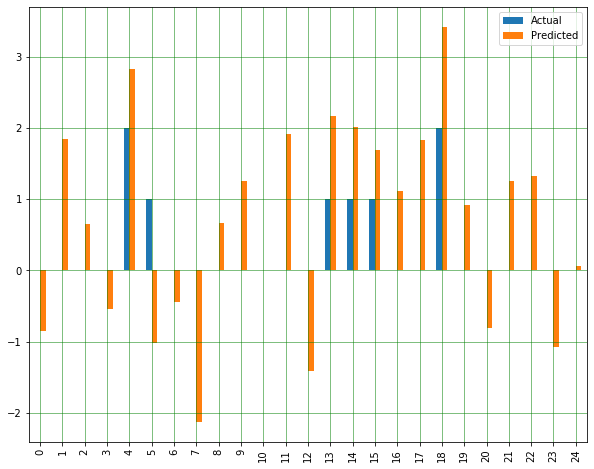

In [169]:
import matplotlib.pyplot as plt
df_compare.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show() 

In [170]:
    # This is value of MAE after normalization

In [270]:
# Let's check for data without normalization
def load_data():
    
    def dummie_and_drop(df, name):
        # Creates a dummy variable, concatenates it and finally drops the original categorical variable.
        # In order not to have redundant variables, one of the dummy variables is dropped too
        dummies = pd.get_dummies(df[name]).rename(columns = lambda x: name + '_' + str(x))
        dummies = dummies.drop(dummies.columns[-1], axis = 1)
        df = pd.concat([df, dummies], axis = 1)
        df.drop(columns = [name], inplace=True, axis=1)

        return df
    
    def convert_to_categorical(df, categorical_variables, categories, need_pickup = True):
        """ 
        The dataframe's selected variables are converted to categorical, and each variable's categories are also specified.
        It is also specified if the "pickup community area" has to be converted into categorical or no. If it is not 
        converted into categorical it is because it's not going to be used in the model.            
        """
        
        if need_pickup:
            begin = 0
        else:
            df.drop(columns = ['pickup_community_area'], inplace = True, axis = 1)
            begin = 1
        
        for i in range(begin, len(categorical_variables)):
            df[categorical_variables[i]] = df[categorical_variables[i]].astype('category').cat.set_categories(categories[i])
        return df
    
    
    def load(name, need_pickup = False, drop_correlated = False):
    
        # This parameter has to be set to True if the "pickup_community_area" variable is needed in the model
        

        # Load needed dataset and choose the useful columns
        df = pd.read_csv(name) #'dataset_train.csv')
        x = df[['pickup_community_area' ,'temperature', 'relative_humidity', 'wind_direction', 'wind_speed', 'precipitation_cat', 
                'sky_level', 'daytype', 'Day Name', 'Month', 'Hour', 'Fare Last Month', 'Trips Last Hour',
                'Trips Last Week (Same Hour)', 'Trips 2 Weeks Ago (Same Hour)', 'Year']]

        # Convert the categorical variables
        categorical_variables = ['pickup_community_area', 'daytype', 'sky_level', 'Day Name', 'Month','Hour', 'Year']
        categories = [[*(range(1,78))], ['U', 'W', 'A'], ['OVC', 'BKN', 'SCT', 'FEW', 'CLR', 'VV '], 
                      ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
                      [*(range(1,13))], [*(range(0, 24))], [2017, 2018, 2019]]

        
        x = convert_to_categorical(x, categorical_variables, categories, need_pickup = need_pickup)

        
        # Make dummy variables with the categorical ones
        if need_pickup:
            begin = 0
        else:
            begin = 1
        for i in range(begin, len(categorical_variables)):
            x = dummie_and_drop(x, name = categorical_variables[i])

        y = df['Trips'].to_numpy()

        if need_pickup == False:
            # If we don't need the pickup, it means this is Neural Network case. Therefore we have to modify Y, in order
            # to have "n_areas" outputs per input (because there are "n_areas" regressions per input)
            n_areas = 77
            y = np.reshape(y, [-1, n_areas]) # If 
        
        if drop_correlated:
            x.drop(columns = ['Trips Last Week (Same Hour)'], inplace = True, axis = 1)
            x.drop(columns = ['Trips 2 Weeks Ago (Same Hour)'], inplace = True, axis = 1)
                
        #x = x.to_numpy()
        
        return (x,y)   
    
# ------------------------------------- MAIN PROGRAM ------------------------

    need_pickup = True 
    drop_correlated = False
    
    
    name_train = 'dataset_train.csv'
    #name_test = 'dataset_test.csv'
    x, y = load(name_train, need_pickup, drop_correlated)
    #x_test, y_test = load(name_test, need_pickup, drop_correlated)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5,shuffle=True)

    
    return (x_train, x_test, y_train, y_test)

In [271]:
x_train, x_test, y_train, y_test = load_data()

C:\Users\Iconsense\Anaconda3\envs\abhishek\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [272]:
x_train.shape

(932316, 134)

In [273]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
reg = lm.fit(x_train, y_train) 
pred = lm.predict(x_test)

In [274]:
y_pred = lm.predict(x_test)

In [275]:
metric(reg)

MAE Train
1.188086442794074
MAE Test
1.1847646077081162
MSE Train
15.762211524847798
MSE Test
15.70067123164249
RMSE Train
3.970165176015703
RMSE Test
3.9624072521186524


In [276]:
reg.intercept_

-0.5611288790778546

In [223]:
with open('reg.pickle', 'wb') as f:
    pickle.dump(reg, f)


In [212]:
df_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_compare = df_pred.head(40)


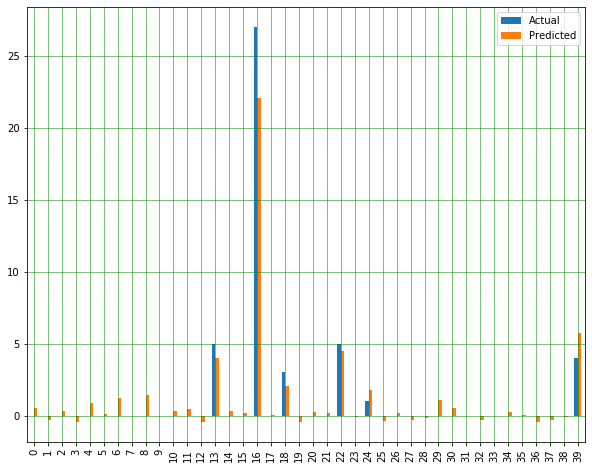

In [213]:
import matplotlib.pyplot as plt
df_compare.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show() 

In [181]:
def load_data():
    
    def dummie_and_drop(df, name):
        # Creates a dummy variable, concatenates it and finally drops the original categorical variable.
        # In order not to have redundant variables, one of the dummy variables is dropped too
        dummies = pd.get_dummies(df[name]).rename(columns = lambda x: name + '_' + str(x))
        dummies = dummies.drop(dummies.columns[-1], axis = 1)
        df = pd.concat([df, dummies], axis = 1)
        df.drop(columns = [name], inplace=True, axis=1)

        return df
    
    def convert_to_categorical(df, categorical_variables, categories, need_pickup = True):
        """ 
        The dataframe's selected variables are converted to categorical, and each variable's categories are also specified.
        It is also specified if the "pickup community area" has to be converted into categorical or no. If it is not 
        converted into categorical it is because it's not going to be used in the model.            
        """
        
        if need_pickup:
            begin = 0
        else:
            df.drop(columns = ['pickup_community_area'], inplace = True, axis = 1)
            begin = 1
        
        for i in range(begin, len(categorical_variables)):
            df[categorical_variables[i]] = df[categorical_variables[i]].astype('category').cat.set_categories(categories[i])
        return df
    
    
    def load(name, need_pickup = False, drop_correlated = False):
    
        # This parameter has to be set to True if the "pickup_community_area" variable is needed in the model
        

        # Load needed dataset and choose the useful columns
        df = pd.read_csv(name) #'dataset_train.csv')
        x = df[['pickup_community_area' ,'temperature', 'relative_humidity', 'wind_direction', 'wind_speed', 'precipitation_cat', 
                'sky_level', 'daytype', 'Day Name', 'Month', 'Hour', 'Fare Last Month', 'Trips Last Hour',
                'Trips Last Week (Same Hour)', 'Trips 2 Weeks Ago (Same Hour)', 'Year']]

        # Convert the categorical variables
        categorical_variables = ['pickup_community_area', 'daytype', 'sky_level', 'Day Name', 'Month','Hour', 'Year']
        categories = [[*(range(1,78))], ['U', 'W', 'A'], ['OVC', 'BKN', 'SCT', 'FEW', 'CLR', 'VV '], 
                      ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
                      [*(range(1,13))], [*(range(0, 24))], [2017, 2018, 2019]]

        
        x = convert_to_categorical(x, categorical_variables, categories, need_pickup = need_pickup)

        
        # Make dummy variables with the categorical ones
        if need_pickup:
            begin = 0
        else:
            begin = 1
        for i in range(begin, len(categorical_variables)):
            x = dummie_and_drop(x, name = categorical_variables[i])

        y = df['Trips'].to_numpy()

        if need_pickup == False:
            # If we don't need the pickup, it means this is Neural Network case. Therefore we have to modify Y, in order
            # to have "n_areas" outputs per input (because there are "n_areas" regressions per input)
            n_areas = 77
            y = np.reshape(y, [-1, n_areas]) # If 
        
        if drop_correlated:
            x.drop(columns = ['Trips Last Week (Same Hour)'], inplace = True, axis = 1)
            x.drop(columns = ['Trips 2 Weeks Ago (Same Hour)'], inplace = True, axis = 1)
        
        
        x_numerical = x[['temperature', 'relative_humidity', 'wind_direction', 'wind_speed', 'precipitation_cat', 
                       'Fare Last Month', 'Trips Last Hour','Trips Last Week (Same Hour)', 'Trips 2 Weeks Ago (Same Hour)']]
        
        from sklearn import preprocessing
        x_numerical = preprocessing.normalize(x_numerical) 
        
        x_df = pd.DataFrame(x_numerical,columns = ['temperature', 'relative_humidity', 'wind_direction', 'wind_speed', 'precipitation_cat', 
                       'Fare Last Month', 'Trips Last Hour','Trips Last Week (Same Hour)', 'Trips 2 Weeks Ago (Same Hour)'])
        x.drop(columns = ['temperature', 'relative_humidity', 'wind_direction', 'wind_speed', 'precipitation_cat', 
                       'Fare Last Month', 'Trips Last Hour','Trips Last Week (Same Hour)', 'Trips 2 Weeks Ago (Same Hour)'],inplace = True, axis = 1) 

        x2 = pd.concat([x_df, x], axis = 1,sort=False)
        
        x2 = x2.to_numpy()
        
        return (x2,y)   
    
# ------------------------------------- MAIN PROGRAM ------------------------

    need_pickup = True 
    drop_correlated = False
    
    
    name_train = 'dataset_train.csv'
#    name_test = 'dataset_test.csv'
    x_train, y_train = load(name_train, need_pickup, drop_correlated)
#    x_test, y_test = load(name_test, need_pickup, drop_correlated)
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.15,shuffle=True)
    
    return (x_train, x_test, y_train, y_test)

In [200]:
x_train, x_test, y_train, y_test = load_data()


from sklearn.linear_model import LinearRegression
lm = LinearRegression()
reg = lm.fit(x_train, y_train) 
pred = lm.predict(x_test)

y_pred = lm.predict(x_test)

metric(reg)

C:\Users\Iconsense\Anaconda3\envs\abhishek\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Traning Score
0.6391008714777922
Test Score
0.6465749210036636
MAE Train
3.124933041502596
MAE Test
3.0951500741879547
MSE Train
96.14723487431992
MSE Test
94.86844598580596
RMSE Train
9.80546964068116
RMSE Test
9.740043428332646


In [195]:
df_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_compare = df_pred.head(25)

In [196]:
#df_compare  # Actual and predicted values from our model

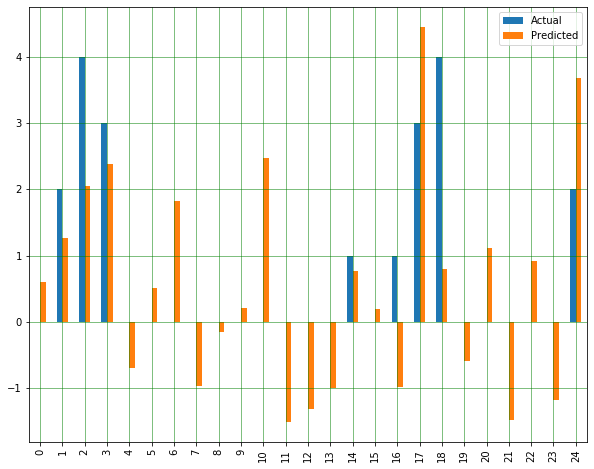

In [197]:
import matplotlib.pyplot as plt
df_compare.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [299]:
# Let's check for data without normalization
def load_data():
    
    def dummie_and_drop(df, name):
        # Creates a dummy variable, concatenates it and finally drops the original categorical variable.
        # In order not to have redundant variables, one of the dummy variables is dropped too
        dummies = pd.get_dummies(df[name]).rename(columns = lambda x: name + '_' + str(x))
        dummies = dummies.drop(dummies.columns[-1], axis = 1)
        df = pd.concat([df, dummies], axis = 1)
        df.drop(columns = [name], inplace=True, axis=1)

        return df
    
    def convert_to_categorical(df, categorical_variables, categories, need_pickup = True):
        """ 
        The dataframe's selected variables are converted to categorical, and each variable's categories are also specified.
        It is also specified if the "pickup community area" has to be converted into categorical or no. If it is not 
        converted into categorical it is because it's not going to be used in the model.            
        """
        
        if need_pickup:
            begin = 0
        else:
            df.drop(columns = ['pickup_community_area'], inplace = True, axis = 1)
            begin = 1
        
        for i in range(begin, len(categorical_variables)):
            df[categorical_variables[i]] = df[categorical_variables[i]].astype('category').cat.set_categories(categories[i])
        return df
    
    
    def load(name, need_pickup = False, drop_correlated = False):
    
        # This parameter has to be set to True if the "pickup_community_area" variable is needed in the model
        

        # Load needed dataset and choose the useful columns
        df = pd.read_csv(name) #'dataset_train.csv')
        x = df[['pickup_community_area' ,'temperature', 'relative_humidity', 'wind_direction', 'wind_speed', 'precipitation_cat', 
                'sky_level', 'daytype', 'Day Name', 'Month', 'Hour', 'Fare Last Month', 'Trips Last Hour',
                'Trips Last Week (Same Hour)', 'Trips 2 Weeks Ago (Same Hour)', 'Year']]

        # Convert the categorical variables
        categorical_variables = ['pickup_community_area', 'daytype', 'sky_level', 'Day Name', 'Month','Hour', 'Year']
        categories = [[*(range(1,78))], ['U', 'W', 'A'], ['OVC', 'BKN', 'SCT', 'FEW', 'CLR', 'VV '], 
                      ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
                      [*(range(1,13))], [*(range(0, 24))], [2017, 2018, 2019]]

        
        x = convert_to_categorical(x, categorical_variables, categories, need_pickup = need_pickup)

        
        # Make dummy variables with the categorical ones
        if need_pickup:
            begin = 0
        else:
            begin = 1
        for i in range(begin, len(categorical_variables)):
            x = dummie_and_drop(x, name = categorical_variables[i])

        y = df['Trips'].to_numpy()

        if need_pickup == False:
            # If we don't need the pickup, it means this is Neural Network case. Therefore we have to modify Y, in order
            # to have "n_areas" outputs per input (because there are "n_areas" regressions per input)
            n_areas = 77
            y = np.reshape(y, [-1, n_areas]) # If 
        
        if drop_correlated:
            x.drop(columns = ['Trips Last Week (Same Hour)'], inplace = True, axis = 1)
            x.drop(columns = ['Trips 2 Weeks Ago (Same Hour)'], inplace = True, axis = 1)
                
        #x = x.to_numpy()
        
        return (x,y)   
    
# ------------------------------------- MAIN PROGRAM ------------------------

    need_pickup = True 
    drop_correlated = False
    
    
    name_train = 'dataset_train.csv'
    #name_test = 'dataset_test.csv'
    x, y = load(name_train, need_pickup, drop_correlated)
    #x_test, y_test = load(name_test, need_pickup, drop_correlated)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5,shuffle=True)

    
    return (x_train, x_test, y_train, y_test)

In [300]:
x_train, x_test, y_train, y_test = load_data()



C:\Users\Iconsense\Anaconda3\envs\abhishek\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [301]:
# OLS regression to calculate best model by comparing AIC values
try:
    import statsmodels.api as sm
except ImportError:
    import scikits.statsmodels.api as sm


In [302]:
x_train = sm.add_constant(x_train, prepend=True) #add a constant

In [303]:
x_test=sm.add_constant(x_test, prepend=True)

In [304]:
res = sm.OLS(y_train,x_train).fit() #create a model and fit it

In [305]:
def metric(rf):
    print("MAE Train")
    train=np.rint(rf.predict(x_train))
    test=np.rint(rf.predict(x_test))
    print(mean_absolute_error(train, y_train))
    print("MAE Test")
    print(mean_absolute_error(test, y_test))

    print("MSE Train")
    print(mean_squared_error(train, y_train))
    print("MSE Test")
    print(mean_squared_error(test, y_test))
    print("RMSE Train")
    print(rmse(train,y_train))
    print("RMSE Test")
    print(rmse(test,y_test))

In [306]:
metric(res)

MAE Train
1.1822000266004231
MAE Test
1.187460045735566
MSE Train
15.60590829718679
MSE Test
15.850647205453944
RMSE Train
3.950431406465222
RMSE Test
3.981287129240234


In [307]:
print(res.summary()) 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                 1.123e+05
Date:                Sun, 19 Apr 2020   Prob (F-statistic):               0.00
Time:                        19:29:37   Log-Likelihood:            -2.6022e+06
No. Observations:              932316   AIC:                         5.205e+06
Df Residuals:                  932182   BIC:                         5.206e+06
Df Model:                         133                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [308]:
# AIC is a very high i.e = 8.337e+06 , so maybe we can get a better model by removing non-significant variables
# We can remove the non-significant variables after comparing p-value with value of alpha(=0.05). 
# Variables like temperature, relative_humidity are coming as non-significant.

x_train = x_train.drop(columns = ['temperature', 'wind_direction','Month_6'])

In [312]:
x_test=x_test.drop(columns = ['temperature', 'wind_direction','Month_6'])

In [309]:
res2 = sm.OLS(y_train,x_train).fit() #create a model and fit it

In [310]:
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                 1.148e+05
Date:                Sun, 19 Apr 2020   Prob (F-statistic):               0.00
Time:                        19:30:38   Log-Likelihood:            -2.6022e+06
No. Observations:              932316   AIC:                         5.205e+06
Df Residuals:                  932185   BIC:                         5.206e+06
Df Model:                         130                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [313]:
metric(res2)

MAE Train
1.1805278467815634
MAE Test
1.1855229342840838
MSE Train
15.605119937875141
MSE Test
15.849345071842594
RMSE Train
3.9503316237849124
RMSE Test
3.9811235941430647


In [ ]:
# The AIC value has not changed when compared to previous value. It is equal to 8.337e+06.
# Almost all variables are having high p-value

Clearly the p-value of all pickup-communities is very high which shows them as insignificant according to OLS 
regression which is not the case for our analysis as it is a very important variable useful in predicting our target
variable which is Trips. So we can conclude that Linear Regression is not a good model for our analysis